In [95]:
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.figure_factory import create_table

from sklearn.linear_model import RidgeCV, Lasso, HuberRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, StandardScaler, MinMaxScaler, PolynomialFeatures, OrdinalEncoder
from sklearn.linear_model import LinearRegression

In [96]:
from utils.helper import get_news_scores, add_indicators, trim_df_columns, reg_model_metrics, get_complexity, print_permutation_importance

### Data Preparation

In [97]:
df_stocks = pd.read_csv('data/jpm_bars_2024-02-27.csv')

In [98]:
# Reset the index
df_stocks['timestamp'] = df_stocks.timestamp.apply(lambda x: x.split(' ')[0])
df_stocks.rename(columns={'timestamp': 'date'}, inplace=True)
df_stocks.drop(['symbol'], axis=1, inplace=True)
df_stocks.set_index('date', inplace=True)

In [99]:
df_stocks.tail()

open    high      low   close     volume  trade_count  \
date                                                                  
2024-02-20  179.19  180.46  178.405  179.73  9667959.0     103049.0   
2024-02-21  179.95  180.99  178.520  180.90  7027857.0      96763.0   
2024-02-22  181.82  183.42  181.240  183.07  9296459.0     111935.0   
2024-02-23  183.81  185.20  183.190  183.99  7104018.0     108247.0   
2024-02-26  183.75  184.46  182.480  183.36  7145393.0      98133.0   

                  vwap  
date                    
2024-02-20  179.737550  
2024-02-21  180.203631  
2024-02-22  182.788280  
2024-02-23  184.196089  
2024-02-26  183.327353

### Engineering Features

In [100]:
#Add Indicators to stock dataframe
df_stocks_full = add_indicators(df_stocks)

LWMA
VIDYA
KAMA
EVWMA
ALMA
MAMA
EV_MACD
SWI
VORTEX
EVSTC


In [101]:
# Dropping columns with NaN values
df_stocks_full = trim_df_columns(df_stocks_full)

In [102]:
df_stocks_full.tail()

open    high      low   close     volume  trade_count  \
date                                                                  
2024-02-20  179.19  180.46  178.405  179.73  9667959.0     103049.0   
2024-02-21  179.95  180.99  178.520  180.90  7027857.0      96763.0   
2024-02-22  181.82  183.42  181.240  183.07  9296459.0     111935.0   
2024-02-23  183.81  185.20  183.190  183.99  7104018.0     108247.0   
2024-02-26  183.75  184.46  182.480  183.36  7145393.0      98133.0   

                  vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  \
date                                                           
2024-02-20  179.737550            175.79          175.553999   
2024-02-21  180.203631            176.03          176.147999   
2024-02-22  182.788280            179.03          176.917110   
2024-02-23  184.196089            179.73          177.702987   
2024-02-26  183.327353            179.87          178.331544   

            EMA_9_period_EMA  ...  BASPN_Sell.    CMO_CMO   WTO_WT1.  \
date                          ...                                      
2024-02-20        177.152321  ...     0.909871  41.425002  64.227919   
2024-02-21        177.901857  ...     0.831243  47.081539  66.508989   
2024-02-22        178.935486  ...     0.794497  55.864784  70.805888   
2024-02-23        179.946388  ...     0.829413  59.065334  74.240796   
2024-02-26        180.629111  ...     0.850936  50.747691  74.235829   

             WTO_WT2.  FISH_10_period_FISH.  ICHIMOKU_TENKAN   APZ_UPPER  \
date                                                                       
2024-02-20  56.488435              1.916395         176.5375  183.303919   
2024-02-21  61.751517              2.355495         176.8025  184.035787   
2024-02-22  65.603433              2.787865         178.0175  185.027366   
2024-02-23  68.945898              3.213397         178.9075  186.023569   
2024-02-26  71.447876              3.172768         178.9075  186.753459   

             APZ_LOWER       VPT_VPT  STC_10_period_STC  
date                                                     
2024-02-20  173.486390  1.960313e+08          30.686989  
2024-02-21  174.211576  2.014374e+08          52.216634  
2024-02-22  175.206759  2.120985e+08          73.334500  
2024-02-23  176.220655  2.133708e+08          88.995794  
2024-02-26  176.980729  2.105560e+08          97.172730  

[5 rows x 92 columns]

In [103]:
df_stocks_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2036 entries, 2016-01-25 to 2024-02-26
Data columns (total 92 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   open                                2036 non-null   float64
 1   high                                2036 non-null   float64
 2   low                                 2036 non-null   float64
 3   close                               2036 non-null   float64
 4   volume                              2036 non-null   float64
 5   trade_count                         2036 non-null   float64
 6   vwap                                2036 non-null   float64
 7   SMM_9_period_SMM                    2036 non-null   float64
 8   SSMA_9_period_SSMA                  2036 non-null   float64
 9   EMA_9_period_EMA                    2036 non-null   float64
 10  DEMA_9_period_DEMA                  2036 non-null   float64
 11  TEMA_9_period_TEMA               

In [104]:
# Check for NaNs
df_stocks_full.isnull().values.any()

False

In [105]:
df_news = pd.read_csv('data/jpm_news_2024-02-27.csv')

In [106]:
df_news.drop(['Unnamed: 0', 'updated_at'], axis=1, inplace=True)
df_news['created_at'] = df_news.created_at.apply(lambda x: x.split(' ')[0])
df_news.rename(columns={'created_at': 'date'}, inplace=True)
df_news = df_news.sort_values('date', ascending=True)
df_news.set_index('date', inplace=True)

In [107]:
df_news.tail()

headline  \
date                                                            
2024-02-26  JP Morgan's Jamie Dimon Says Rising Defaults W...   
2024-02-26  JP Morgan's Jamie Dimon Says He's A Big Optimi...   
2024-02-26  CNBC Halftime Report Final Trades: JP Morgan C...   
2024-02-26  JPMorgan's Jamie Dimon On CNBC Said There Are ...   
2024-02-26  Jamie Dimon Calls Himself 'Big' AI Optimist, S...   

                                                      summary  \
date                                                            
2024-02-26                                                NaN   
2024-02-26                                                NaN   
2024-02-26                                                NaN   
2024-02-26                                                NaN   
2024-02-26  &#34;This is not hype,&#34; Dimon said. &#34;T...   

                                                          url news_type  \
date                                                                      
2024-02-26  https://www.benzinga.com/economics/macro-econo...   neutral   
2024-02-26  https://www.benzinga.com/economics/macro-econo...   neutral   
2024-02-26  https://www.benzinga.com/news/24/02/37317653/c...   neutral   
2024-02-26  https://www.benzinga.com/news/24/02/37316386/j...   neutral   
2024-02-26  https://www.benzinga.com/news/24/02/37319810/j...   neutral   

               score                          symbols  
date                                                   
2024-02-26  0.998900                   ['JPM', 'SPY']  
2024-02-26  0.998359  ['GOOGL', 'JPM', 'MSFT', 'SPY']  
2024-02-26  0.998757  ['JPM', 'QCOM', 'STLD', 'URNM']  
2024-02-26  0.998888                   ['JPM', 'SPY']  
2024-02-26  0.993206                          ['JPM']

In [108]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4463 entries, 2015-01-02 to 2024-02-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   headline   4463 non-null   object 
 1   summary    1823 non-null   object 
 2   url        4463 non-null   object 
 3   news_type  4463 non-null   object 
 4   score      4463 non-null   float64
 5   symbols    4463 non-null   object 
dtypes: float64(1), object(5)
memory usage: 244.1+ KB


In [109]:
# Getting the news scores regarding the stock
df_score = get_news_scores(df = df_news)

In [110]:
df_score.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1738 entries, 2015-01-02 to 2024-02-26
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   score      1738 non-null   float64
 1   news_type  1738 non-null   object 
dtypes: float64(1), object(1)
memory usage: 40.7+ KB


In [111]:
df_score['news_type'].value_counts()

news_type
neutral     1682
negative      28
positive      28
Name: count, dtype: int64

In [112]:
df_score['news_type'].tail()

date
2024-02-21    neutral
2024-02-22    neutral
2024-02-23    neutral
2024-02-24    neutral
2024-02-26    neutral
Name: news_type, dtype: object

In [113]:
oe = OrdinalEncoder(categories=[['positive', 'neutral', 'negative']])
df_score[['news_type']] = oe.fit_transform(df_score[['news_type']])

In [114]:
df_score['news_type'].tail()

date
2024-02-21    1.0
2024-02-22    1.0
2024-02-23    1.0
2024-02-24    1.0
2024-02-26    1.0
Name: news_type, dtype: float64

In [115]:
# Check for NaNs
df_score.isnull().values.any()

False

In [116]:
df_score.shape[0], df_stocks_full.shape[0]

(1738, 2036)

In [117]:
# Adding news scores to stock dataframe
df = df_stocks_full.join(df_score, how='left', on='date')

In [118]:
df.tail()

open    high      low   close     volume  trade_count  \
date                                                                  
2024-02-20  179.19  180.46  178.405  179.73  9667959.0     103049.0   
2024-02-21  179.95  180.99  178.520  180.90  7027857.0      96763.0   
2024-02-22  181.82  183.42  181.240  183.07  9296459.0     111935.0   
2024-02-23  183.81  185.20  183.190  183.99  7104018.0     108247.0   
2024-02-26  183.75  184.46  182.480  183.36  7145393.0      98133.0   

                  vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  \
date                                                           
2024-02-20  179.737550            175.79          175.553999   
2024-02-21  180.203631            176.03          176.147999   
2024-02-22  182.788280            179.03          176.917110   
2024-02-23  184.196089            179.73          177.702987   
2024-02-26  183.327353            179.87          178.331544   

            EMA_9_period_EMA  ...   WTO_WT1.   WTO_WT2.  FISH_10_period_FISH.  \
date                          ...                                               
2024-02-20        177.152321  ...  64.227919  56.488435              1.916395   
2024-02-21        177.901857  ...  66.508989  61.751517              2.355495   
2024-02-22        178.935486  ...  70.805888  65.603433              2.787865   
2024-02-23        179.946388  ...  74.240796  68.945898              3.213397   
2024-02-26        180.629111  ...  74.235829  71.447876              3.172768   

            ICHIMOKU_TENKAN   APZ_UPPER   APZ_LOWER       VPT_VPT  \
date                                                                
2024-02-20         176.5375  183.303919  173.486390  1.960313e+08   
2024-02-21         176.8025  184.035787  174.211576  2.014374e+08   
2024-02-22         178.0175  185.027366  175.206759  2.120985e+08   
2024-02-23         178.9075  186.023569  176.220655  2.133708e+08   
2024-02-26         178.9075  186.753459  176.980729  2.105560e+08   

            STC_10_period_STC     score  news_type  
date                                                
2024-02-20          30.686989  0.979125        1.0  
2024-02-21          52.216634  0.998664        1.0  
2024-02-22          73.334500  0.998633        1.0  
2024-02-23          88.995794  0.998382        1.0  
2024-02-26          97.172730  0.997006        1.0  

[5 rows x 94 columns]

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2036 entries, 2016-01-25 to 2024-02-26
Data columns (total 94 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   open                                2036 non-null   float64
 1   high                                2036 non-null   float64
 2   low                                 2036 non-null   float64
 3   close                               2036 non-null   float64
 4   volume                              2036 non-null   float64
 5   trade_count                         2036 non-null   float64
 6   vwap                                2036 non-null   float64
 7   SMM_9_period_SMM                    2036 non-null   float64
 8   SSMA_9_period_SSMA                  2036 non-null   float64
 9   EMA_9_period_EMA                    2036 non-null   float64
 10  DEMA_9_period_DEMA                  2036 non-null   float64
 11  TEMA_9_period_TEMA               

In [120]:
score_neutral = df.query("news_type == 1")[['score']]
median_score = score_neutral['score'].median()

In [121]:
# Replacing the NaN with 'NEUTRAL'
df.fillna(1, inplace=True)

In [122]:
df['score'] = df['score'].replace(1, median_score)

In [123]:
df['news_type'].value_counts()

news_type
1.0    2001
0.0      23
2.0      12
Name: count, dtype: int64

In [124]:
df.describe()

open         high          low        close        volume  \
count  2036.000000  2036.000000  2036.000000  2036.000000  2.036000e+03   
mean    116.000474   117.100800   114.919096   116.023143  1.550009e+07   
std      29.278627    29.499483    29.061474    29.289033  7.335890e+06   
min      53.910000    53.910000    52.500000    53.070000  1.604000e+05   
25%      96.577500    97.777500    95.602500    96.840000  1.075182e+07   
50%     113.685000   114.741950   112.787000   113.770000  1.399339e+07   
75%     138.620000   139.965000   137.660000   138.662500  1.785151e+07   
max     183.810000   185.200000   183.190000   183.990000  7.290765e+07   

         trade_count         vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  \
count    2036.000000  2036.000000       2036.000000         2036.000000   
mean   113763.598723   116.018945        115.814386          115.549418   
std     53159.562623    29.284126         29.219380           28.984164   
min         1.000000    53.284123         57.010000           56.749482   
25%     79434.750000    96.802605         96.837500           97.079898   
50%    101420.500000   113.913441        114.180000          113.096138   
75%    130693.000000   138.744615        138.450000          137.330797   
max    457367.000000   184.196089        179.870000          178.331544   

       EMA_9_period_EMA  ...     WTO_WT1.     WTO_WT2.  FISH_10_period_FISH.  \
count       2036.000000  ...  2036.000000  2036.000000           2036.000000   
mean         115.780566  ...    10.180778    10.069303              0.450548   
std           29.122558  ...    35.833199    35.309024              1.794916   
min           56.131166  ...   -75.865062   -77.019343             -4.937305   
25%           96.729840  ...   -19.011626   -18.168264             -0.864048   
50%          113.725621  ...    13.279221    12.788160              0.429328   
75%          137.688980  ...    41.526150    40.905957              1.734982   
max          180.629111  ...    81.244741    79.325133              6.302216   

       ICHIMOKU_TENKAN    APZ_UPPER    APZ_LOWER       VPT_VPT  \
count      2036.000000  2036.000000  2036.000000  2.036000e+03   
mean        115.704559   120.338729   111.646918  2.498524e+08   
std          29.124974    30.244847    28.610309  3.665728e+08   
min          55.820000    58.767575    52.659098 -3.914145e+08   
25%          96.221250   101.331995    91.504905 -6.680449e+07   
50%         112.807500   117.815301   109.378819  1.717333e+08   
75%         138.102200   143.231472   133.629654  6.146102e+08   
max         178.907500   186.753459   176.980729  9.704963e+08   

       STC_10_period_STC        score    news_type  
count        2036.000000  2036.000000  2036.000000  
mean           51.758732     0.989575     0.994597  
std            43.794787     0.045864     0.131034  
min             0.000000     0.500724     0.000000  
25%             1.185105     0.997809     1.000000  
50%            57.442881     0.998227     1.000000  
75%            99.632660     0.998441     1.000000  
max           100.000000     0.999355     2.000000  

[8 rows x 94 columns]

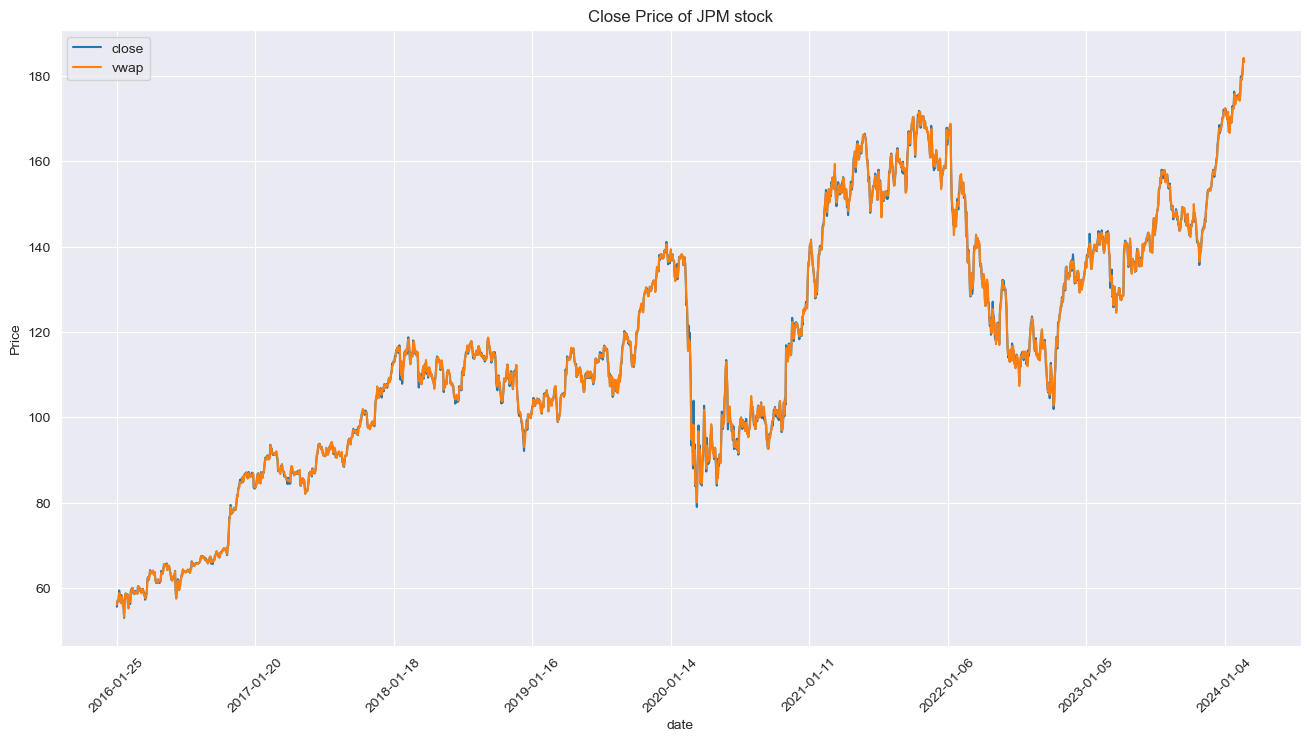

In [125]:
plt.figure(figsize=(16,8))
df['close'].plot(kind='line')
df['vwap'].plot(kind='line')
plt.xticks(rotation = 45)
plt.title('Close Price of JPM stock')
plt.ylabel('Price')
plt.legend()
plt.show()


##### The 'vwap' is a feature variable which is an independent, and 'close' price is the target, which is a dependent variable (explainable).  

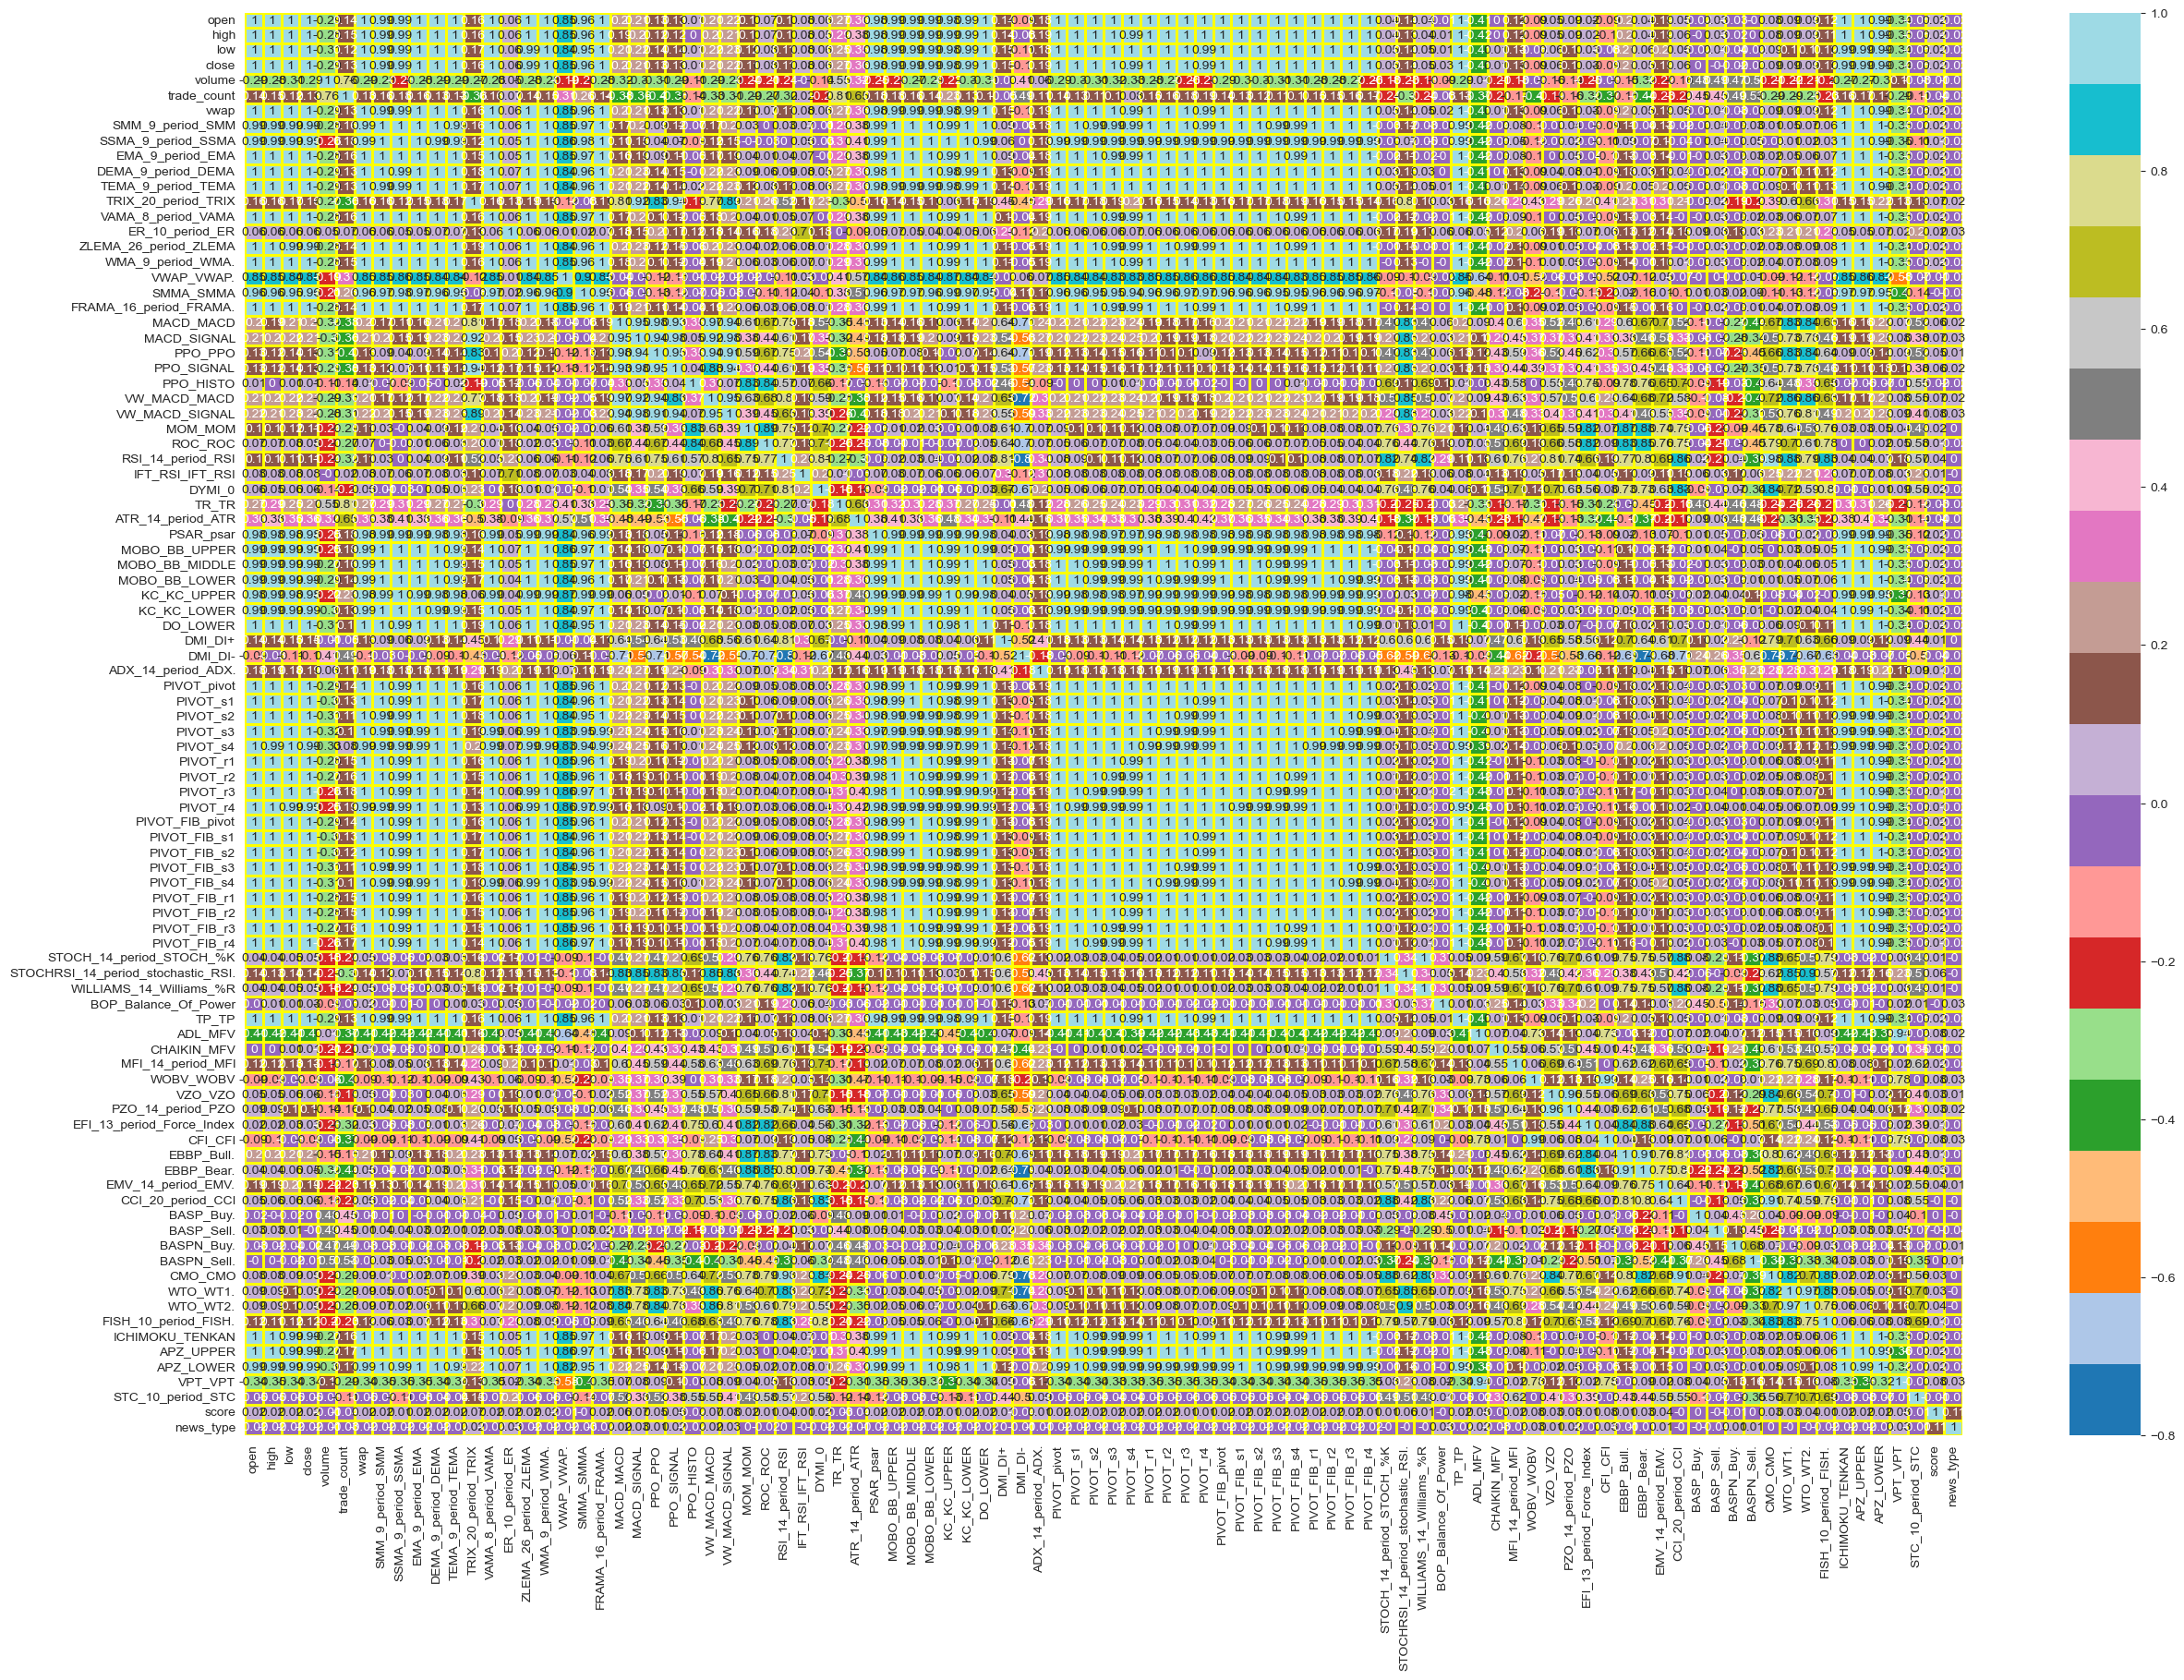

In [126]:
corr =df.corr()
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
sns.heatmap(corr.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [127]:
corr_matrix = pd.DataFrame(corr)
corr_matrix = corr_matrix.round(decimals=2)
create_table(corr_matrix['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

#### Removing highly correlated features, the 'close' price is the target feature

In [128]:
low_corr_columns = ['close', 'vwap', 'volume', 'trade_count', 'TRIX_20_period_TRIX', 'ER_10_period_ER', 'PPO_HISTO', 'VW_MACD_MACD', 'MOM_MOM', 'ROC_ROC', 'RSI_14_period_RSI', 'IFT_RSI_IFT_RSI', 'DYMI_0', 'TR_TR', 'BOP_Balance_Of_Power', 'ADL_MFV', 'VZO_VZO', 'EBBP_Bull.', 'EBBP_Bear.', 'BASPN_Buy.', 'BASPN_Sell.', 'VPT_VPT', 'score', 'news_type']

In [129]:
df_corr  = df #df[low_corr_columns]

In [130]:
#msno.bar(df_corr)

In [131]:
df_corr.tail()

open    high      low   close     volume  trade_count  \
date                                                                  
2024-02-20  179.19  180.46  178.405  179.73  9667959.0     103049.0   
2024-02-21  179.95  180.99  178.520  180.90  7027857.0      96763.0   
2024-02-22  181.82  183.42  181.240  183.07  9296459.0     111935.0   
2024-02-23  183.81  185.20  183.190  183.99  7104018.0     108247.0   
2024-02-26  183.75  184.46  182.480  183.36  7145393.0      98133.0   

                  vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  \
date                                                           
2024-02-20  179.737550            175.79          175.553999   
2024-02-21  180.203631            176.03          176.147999   
2024-02-22  182.788280            179.03          176.917110   
2024-02-23  184.196089            179.73          177.702987   
2024-02-26  183.327353            179.87          178.331544   

            EMA_9_period_EMA  ...   WTO_WT1.   WTO_WT2.  FISH_10_period_FISH.  \
date                          ...                                               
2024-02-20        177.152321  ...  64.227919  56.488435              1.916395   
2024-02-21        177.901857  ...  66.508989  61.751517              2.355495   
2024-02-22        178.935486  ...  70.805888  65.603433              2.787865   
2024-02-23        179.946388  ...  74.240796  68.945898              3.213397   
2024-02-26        180.629111  ...  74.235829  71.447876              3.172768   

            ICHIMOKU_TENKAN   APZ_UPPER   APZ_LOWER       VPT_VPT  \
date                                                                
2024-02-20         176.5375  183.303919  173.486390  1.960313e+08   
2024-02-21         176.8025  184.035787  174.211576  2.014374e+08   
2024-02-22         178.0175  185.027366  175.206759  2.120985e+08   
2024-02-23         178.9075  186.023569  176.220655  2.133708e+08   
2024-02-26         178.9075  186.753459  176.980729  2.105560e+08   

            STC_10_period_STC     score  news_type  
date                                                
2024-02-20          30.686989  0.979125        1.0  
2024-02-21          52.216634  0.998664        1.0  
2024-02-22          73.334500  0.998633        1.0  
2024-02-23          88.995794  0.998382        1.0  
2024-02-26          97.172730  0.997006        1.0  

[5 rows x 94 columns]

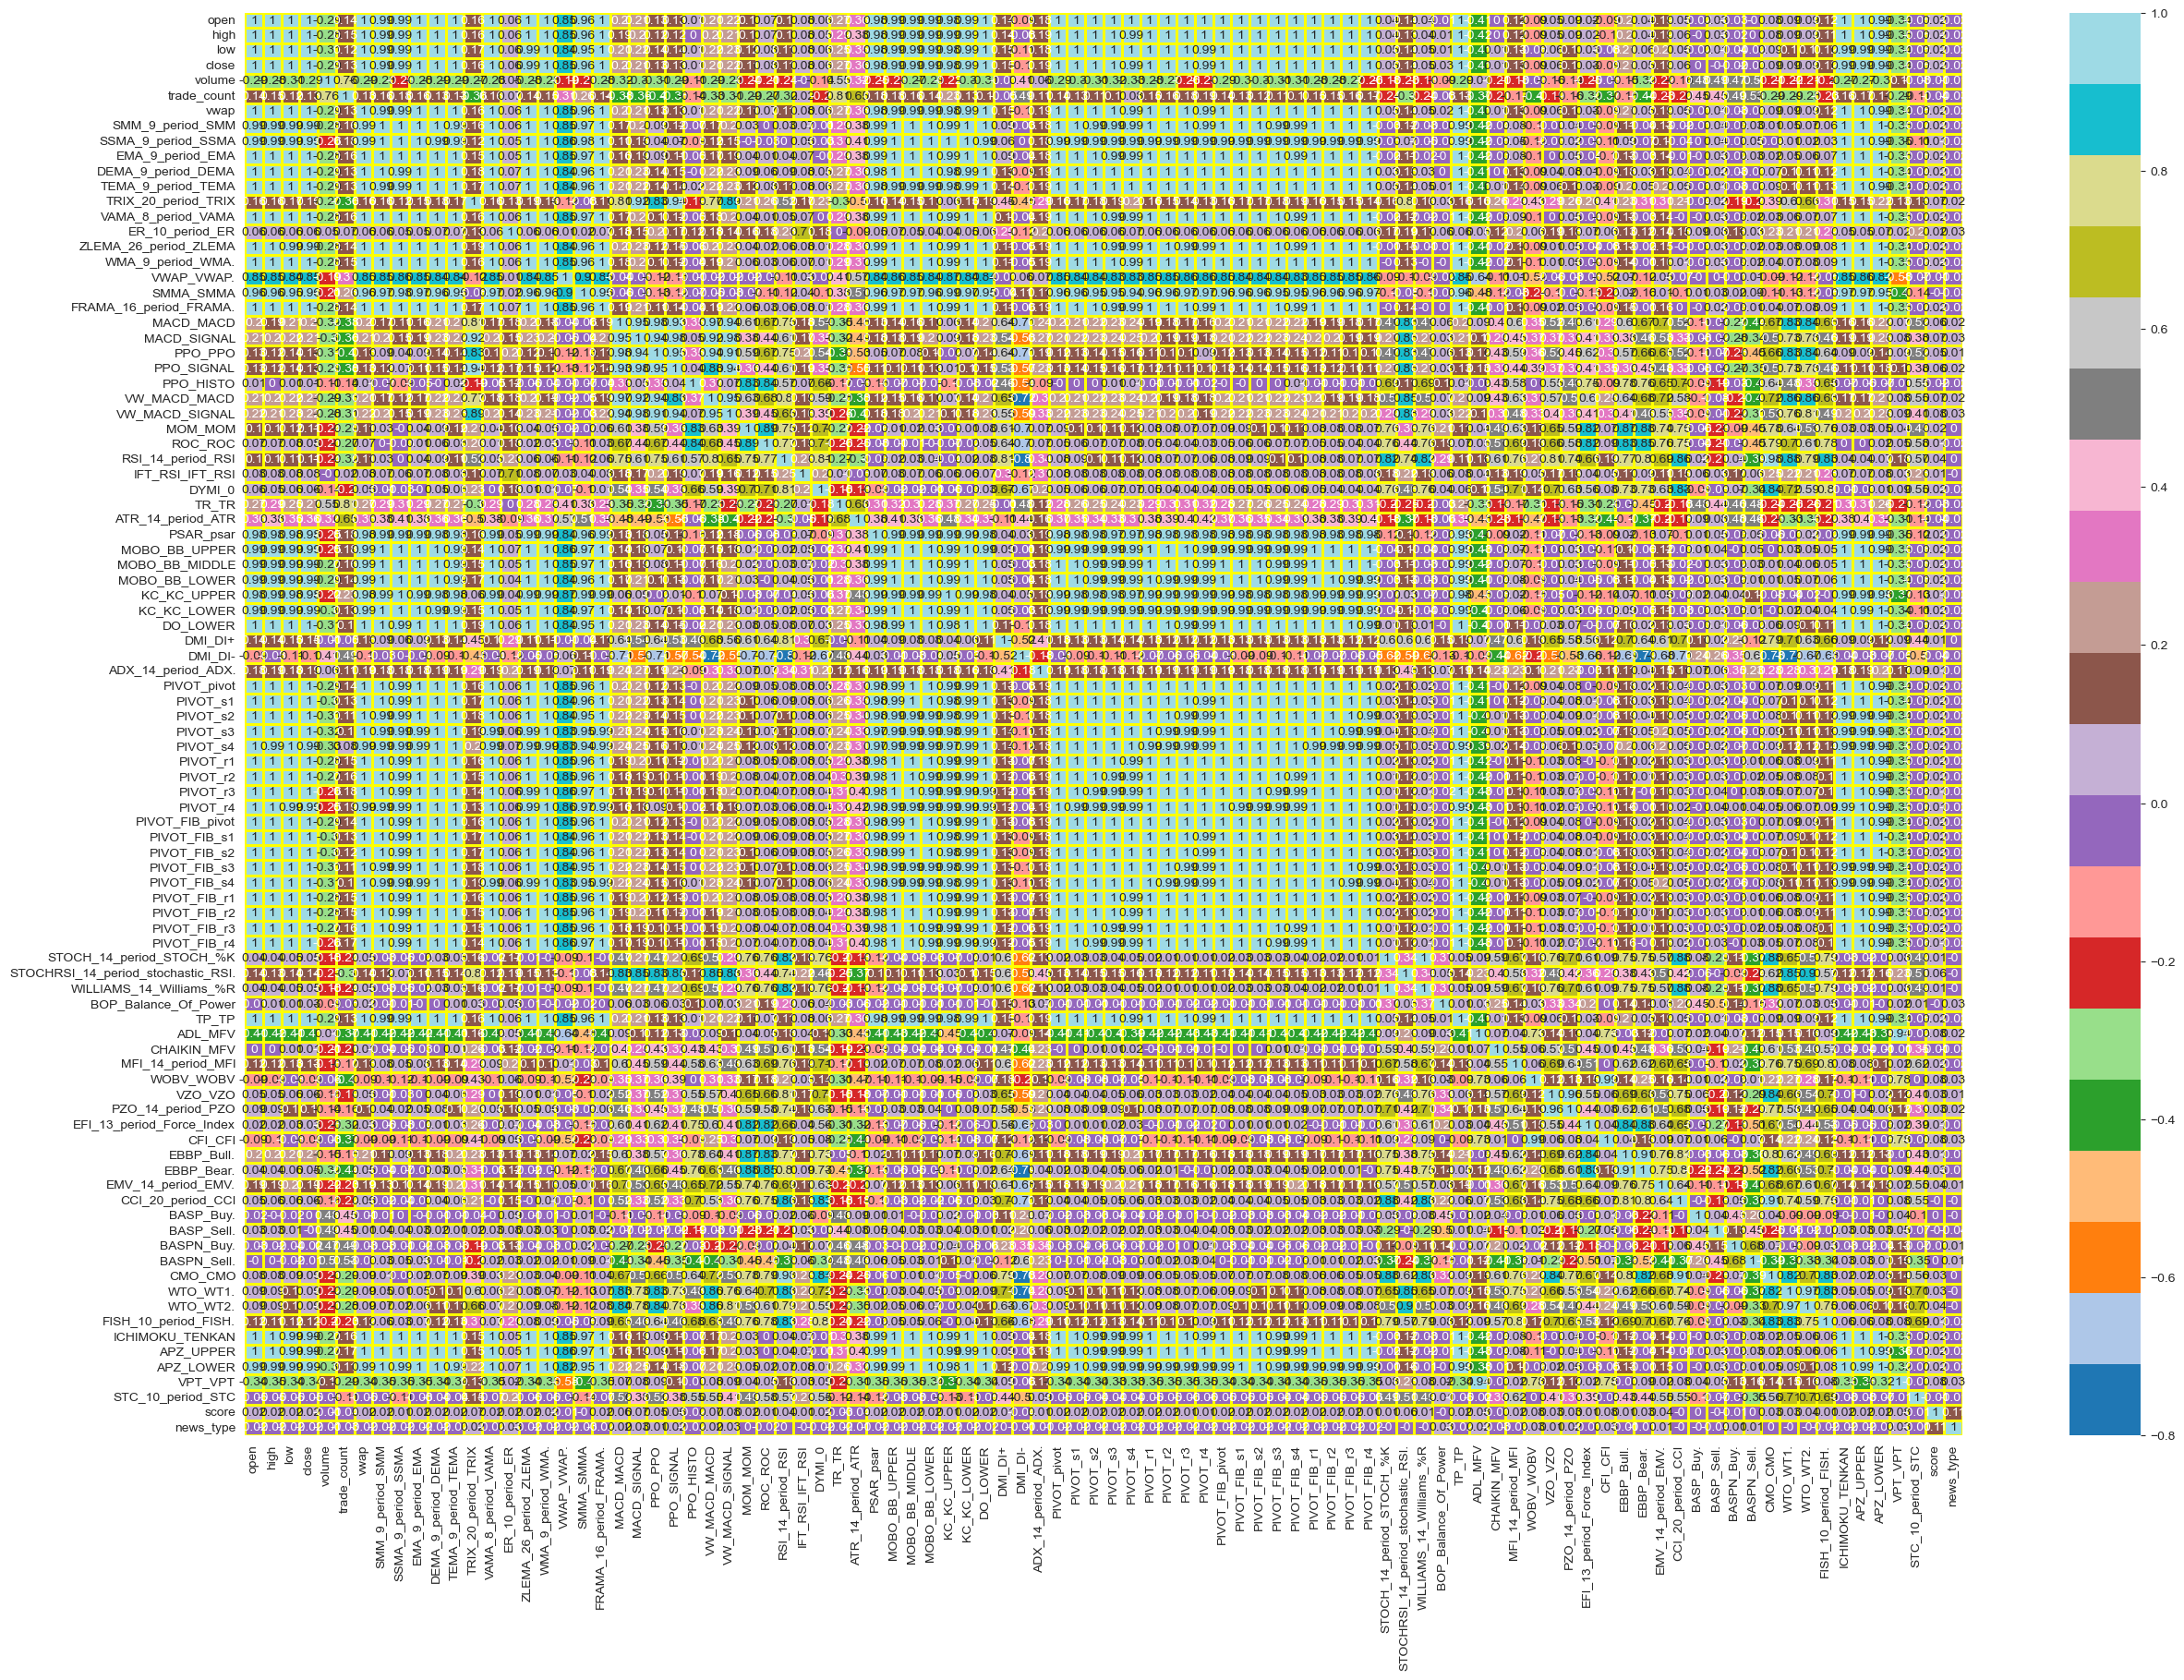

In [132]:
plt.figure(figsize=(30,20))
# setting the parameter values 
annot = True
corr_low =df_corr.corr()
sns.heatmap(corr_low.round(2),annot=annot,cmap="tab20", linewidths=2, linecolor='yellow')
plt.show()

In [133]:
# Correlations to the Target feature 'close'
corr_matrix = pd.DataFrame(corr_low)
corr_matrix = corr_matrix.round(decimals=2)
create_table(corr_matrix['close'].sort_values(ascending=False).to_frame(), index_title='features', index=True, )

In [134]:
df_corr.describe()

open         high          low        close        volume  \
count  2036.000000  2036.000000  2036.000000  2036.000000  2.036000e+03   
mean    116.000474   117.100800   114.919096   116.023143  1.550009e+07   
std      29.278627    29.499483    29.061474    29.289033  7.335890e+06   
min      53.910000    53.910000    52.500000    53.070000  1.604000e+05   
25%      96.577500    97.777500    95.602500    96.840000  1.075182e+07   
50%     113.685000   114.741950   112.787000   113.770000  1.399339e+07   
75%     138.620000   139.965000   137.660000   138.662500  1.785151e+07   
max     183.810000   185.200000   183.190000   183.990000  7.290765e+07   

         trade_count         vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  \
count    2036.000000  2036.000000       2036.000000         2036.000000   
mean   113763.598723   116.018945        115.814386          115.549418   
std     53159.562623    29.284126         29.219380           28.984164   
min         1.000000    53.284123         57.010000           56.749482   
25%     79434.750000    96.802605         96.837500           97.079898   
50%    101420.500000   113.913441        114.180000          113.096138   
75%    130693.000000   138.744615        138.450000          137.330797   
max    457367.000000   184.196089        179.870000          178.331544   

       EMA_9_period_EMA  ...     WTO_WT1.     WTO_WT2.  FISH_10_period_FISH.  \
count       2036.000000  ...  2036.000000  2036.000000           2036.000000   
mean         115.780566  ...    10.180778    10.069303              0.450548   
std           29.122558  ...    35.833199    35.309024              1.794916   
min           56.131166  ...   -75.865062   -77.019343             -4.937305   
25%           96.729840  ...   -19.011626   -18.168264             -0.864048   
50%          113.725621  ...    13.279221    12.788160              0.429328   
75%          137.688980  ...    41.526150    40.905957              1.734982   
max          180.629111  ...    81.244741    79.325133              6.302216   

       ICHIMOKU_TENKAN    APZ_UPPER    APZ_LOWER       VPT_VPT  \
count      2036.000000  2036.000000  2036.000000  2.036000e+03   
mean        115.704559   120.338729   111.646918  2.498524e+08   
std          29.124974    30.244847    28.610309  3.665728e+08   
min          55.820000    58.767575    52.659098 -3.914145e+08   
25%          96.221250   101.331995    91.504905 -6.680449e+07   
50%         112.807500   117.815301   109.378819  1.717333e+08   
75%         138.102200   143.231472   133.629654  6.146102e+08   
max         178.907500   186.753459   176.980729  9.704963e+08   

       STC_10_period_STC        score    news_type  
count        2036.000000  2036.000000  2036.000000  
mean           51.758732     0.989575     0.994597  
std            43.794787     0.045864     0.131034  
min             0.000000     0.500724     0.000000  
25%             1.185105     0.997809     1.000000  
50%            57.442881     0.998227     1.000000  
75%            99.632660     0.998441     1.000000  
max           100.000000     0.999355     2.000000  

[8 rows x 94 columns]

array([[<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'high'}>,
        <Axes: title={'center': 'low'}>,
        <Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'trade_count'}>,
        <Axes: title={'center': 'vwap'}>,
        <Axes: title={'center': 'SMM_9_period_SMM'}>,
        <Axes: title={'center': 'SSMA_9_period_SSMA'}>,
        <Axes: title={'center': 'EMA_9_period_EMA'}>],
       [<Axes: title={'center': 'DEMA_9_period_DEMA'}>,
        <Axes: title={'center': 'TEMA_9_period_TEMA'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>,
        <Axes: title={'center': 'VAMA_8_period_VAMA'}>,
        <Axes: title={'center': 'ER_10_period_ER'}>,
        <Axes: title={'center': 'ZLEMA_26_period_ZLEMA'}>,
        <Axes: title={'center': 'WMA_9_period_WMA.'}>,
        <Axes: title={'center': 'VWAP_VWAP.'}>,
        <Axes: title={'center': 'SMMA_SMMA'}>,
        <Axes: title={'center': 'FRAMA_16_per

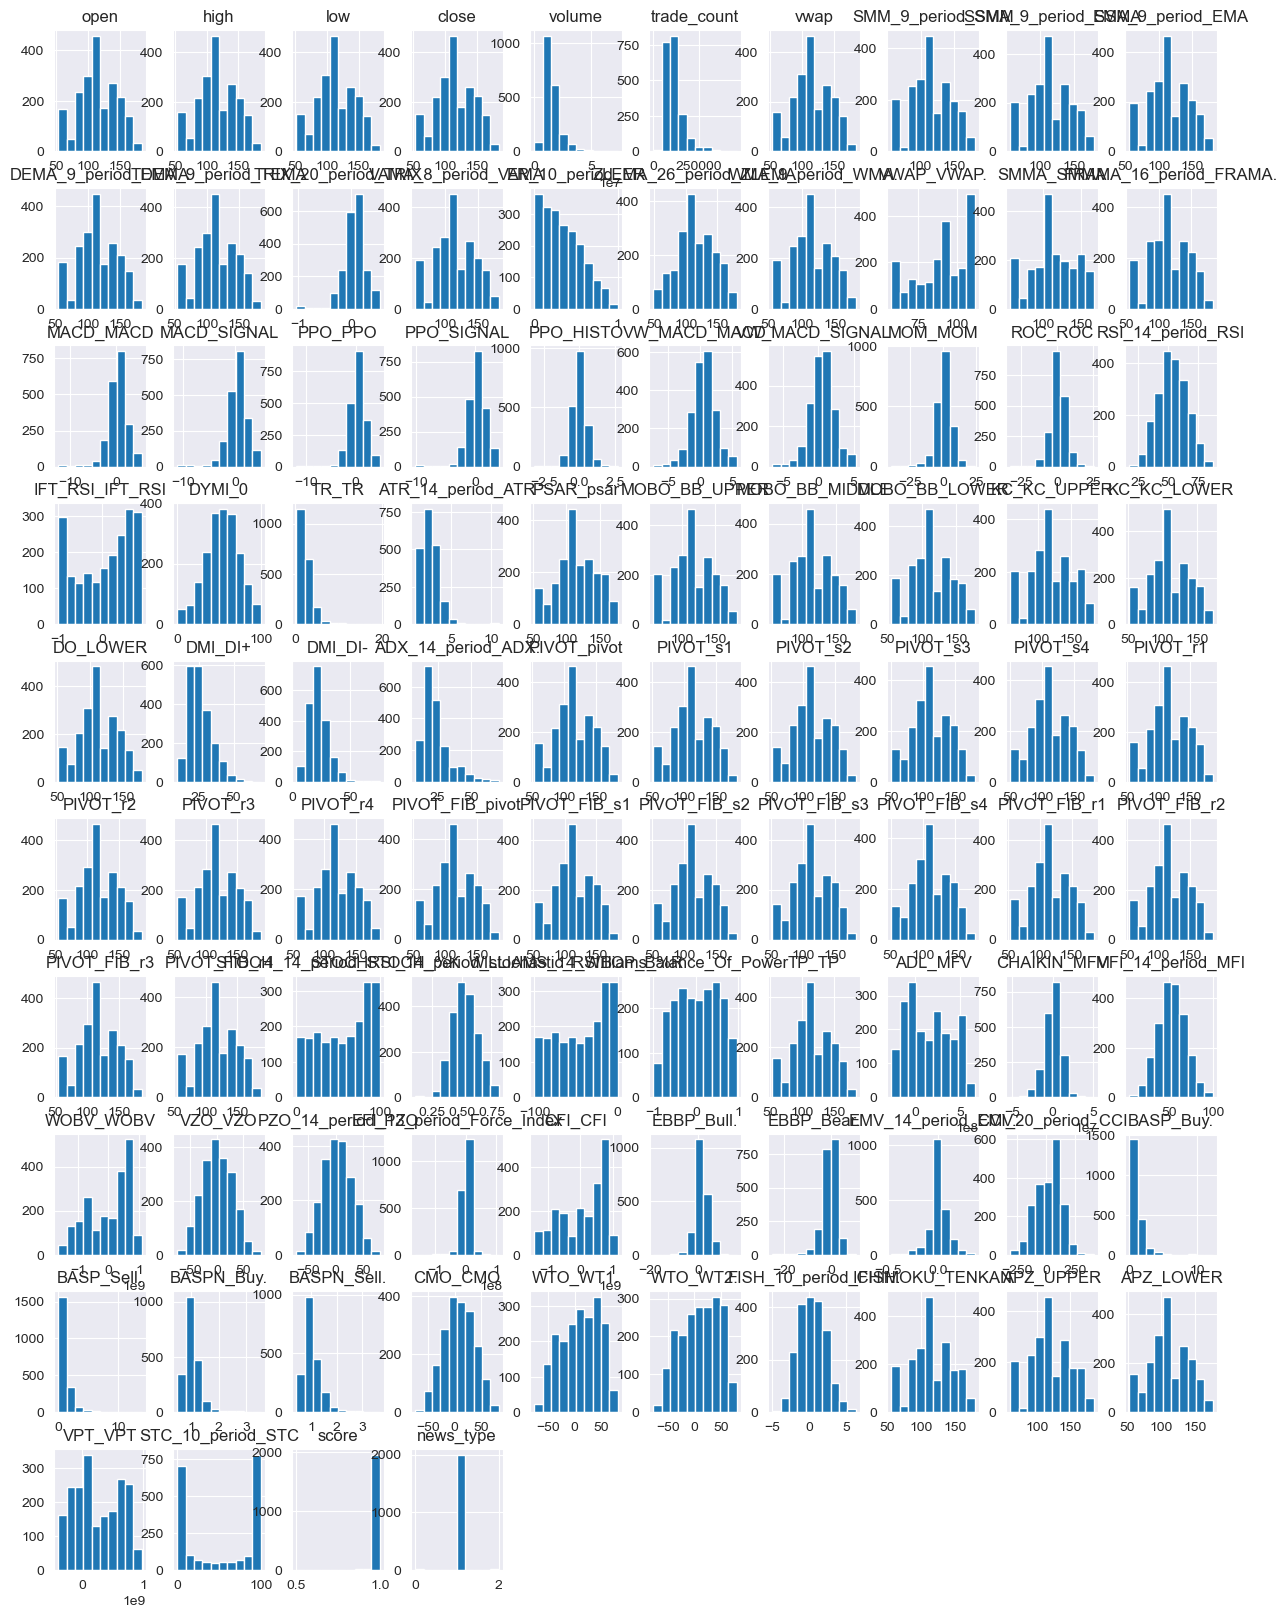

In [135]:
fig = plt.figure(figsize=(15, 20))
ax = fig.gca()
df_corr.hist(ax=ax)

##### from the dataframe describe mean and std are not 0 and 1, and from the histogram we can see the dataset is skewed on left and right
##### even the 'vwap' feature is highly correlated to the target, it is kept. The "Volume Weighted Average Price" is a benchmark indicator for traders

In [136]:
#Scaling dataset before Normalising it
data = df_corr.copy()
scaler = StandardScaler()
data = scaler.fit_transform(data)

# Normalization of the dataset
trans = QuantileTransformer(n_quantiles=1000, output_distribution='normal')
trans_array = trans.fit_transform(df_corr)
df_norm = pd.DataFrame(trans_array)
named_columns = df_corr.columns
numer_columns = df_norm.copy().columns
tuples = [(key, value) for i, (key, value) in enumerate(zip(numer_columns, named_columns))]
columns = dict(tuples)
df_norm.rename(columns=columns, inplace=True)
df_norm = df_norm[named_columns]
df_norm.index = df.index
df_norm.describe()

open         high          low        close       volume  \
count  2036.000000  2036.000000  2036.000000  2036.000000  2036.000000   
mean      0.000435     0.000104     0.000058     0.000071    -0.000084   
std       1.010703     1.009505     1.009499     1.009159     1.009185   
min      -5.199338    -5.199338    -5.199338    -5.199338    -5.199338   
25%      -0.674151    -0.675251    -0.674412    -0.675803    -0.674037   
50%      -0.000294    -0.000442     0.000062    -0.000322     0.000113   
75%       0.674232     0.675230     0.674584     0.674240     0.674686   
max       5.199338     5.199338     5.199338     5.199338     5.199338   

       trade_count         vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  \
count  2036.000000  2036.000000       2036.000000         2036.000000   
mean     -0.000494     0.000010         -0.003976           -0.000059   
std       1.011093     1.009327          1.027187            1.009897   
min      -5.199338    -5.199338         -5.199338           -5.199338   
25%      -0.674623    -0.675073         -0.673705           -0.673900   
50%       0.000680     0.000656          0.001633            0.000045   
75%       0.674593     0.673924          0.675277            0.674690   
max       5.199338     5.199338          5.199338            5.199338   

       EMA_9_period_EMA  ...     WTO_WT1.     WTO_WT2.  FISH_10_period_FISH.  \
count       2036.000000  ...  2036.000000  2036.000000           2036.000000   
mean           0.000013  ...     0.000029     0.000004             -0.000061   
std            1.009893  ...     1.009406     1.009463              1.009280   
min           -5.199338  ...    -5.199338    -5.199338             -5.199338   
25%           -0.674479  ...    -0.675103    -0.675703             -0.674323   
50%           -0.000360  ...     0.000119     0.000580             -0.000481   
75%            0.674280  ...     0.674307     0.674257              0.674359   
max            5.199338  ...     5.199338     5.199338              5.199338   

       ICHIMOKU_TENKAN    APZ_UPPER    APZ_LOWER      VPT_VPT  \
count      2036.000000  2036.000000  2036.000000  2036.000000   
mean         -0.000005     0.000038    -0.000054    -0.000028   
std           1.017448     1.009682     1.009952     1.009278   
min          -5.199338    -5.199338    -5.199338    -5.199338   
25%          -0.674532    -0.674592    -0.673969    -0.674768   
50%          -0.000537    -0.000012     0.000029    -0.000787   
75%           0.676016     0.674272     0.674091     0.674319   
max           5.199338     5.199338     5.199338     5.199338   

       STC_10_period_STC        score    news_type  
count        2036.000000  2036.000000  2036.000000  
mean            0.079740    -0.000670    -0.020693  
std             3.374855     1.002938     0.681594  
min            -5.199338    -5.199338    -5.199338  
25%            -0.674506    -0.673877     0.007527  
50%            -0.000411     0.016310     0.007527  
75%             0.675142     0.674740     0.007527  
max             5.199338     5.199338     5.199338  

[8 rows x 94 columns]

array([[<Axes: title={'center': 'open'}>,
        <Axes: title={'center': 'high'}>,
        <Axes: title={'center': 'low'}>,
        <Axes: title={'center': 'close'}>,
        <Axes: title={'center': 'volume'}>,
        <Axes: title={'center': 'trade_count'}>,
        <Axes: title={'center': 'vwap'}>,
        <Axes: title={'center': 'SMM_9_period_SMM'}>,
        <Axes: title={'center': 'SSMA_9_period_SSMA'}>,
        <Axes: title={'center': 'EMA_9_period_EMA'}>],
       [<Axes: title={'center': 'DEMA_9_period_DEMA'}>,
        <Axes: title={'center': 'TEMA_9_period_TEMA'}>,
        <Axes: title={'center': 'TRIX_20_period_TRIX'}>,
        <Axes: title={'center': 'VAMA_8_period_VAMA'}>,
        <Axes: title={'center': 'ER_10_period_ER'}>,
        <Axes: title={'center': 'ZLEMA_26_period_ZLEMA'}>,
        <Axes: title={'center': 'WMA_9_period_WMA.'}>,
        <Axes: title={'center': 'VWAP_VWAP.'}>,
        <Axes: title={'center': 'SMMA_SMMA'}>,
        <Axes: title={'center': 'FRAMA_16_per

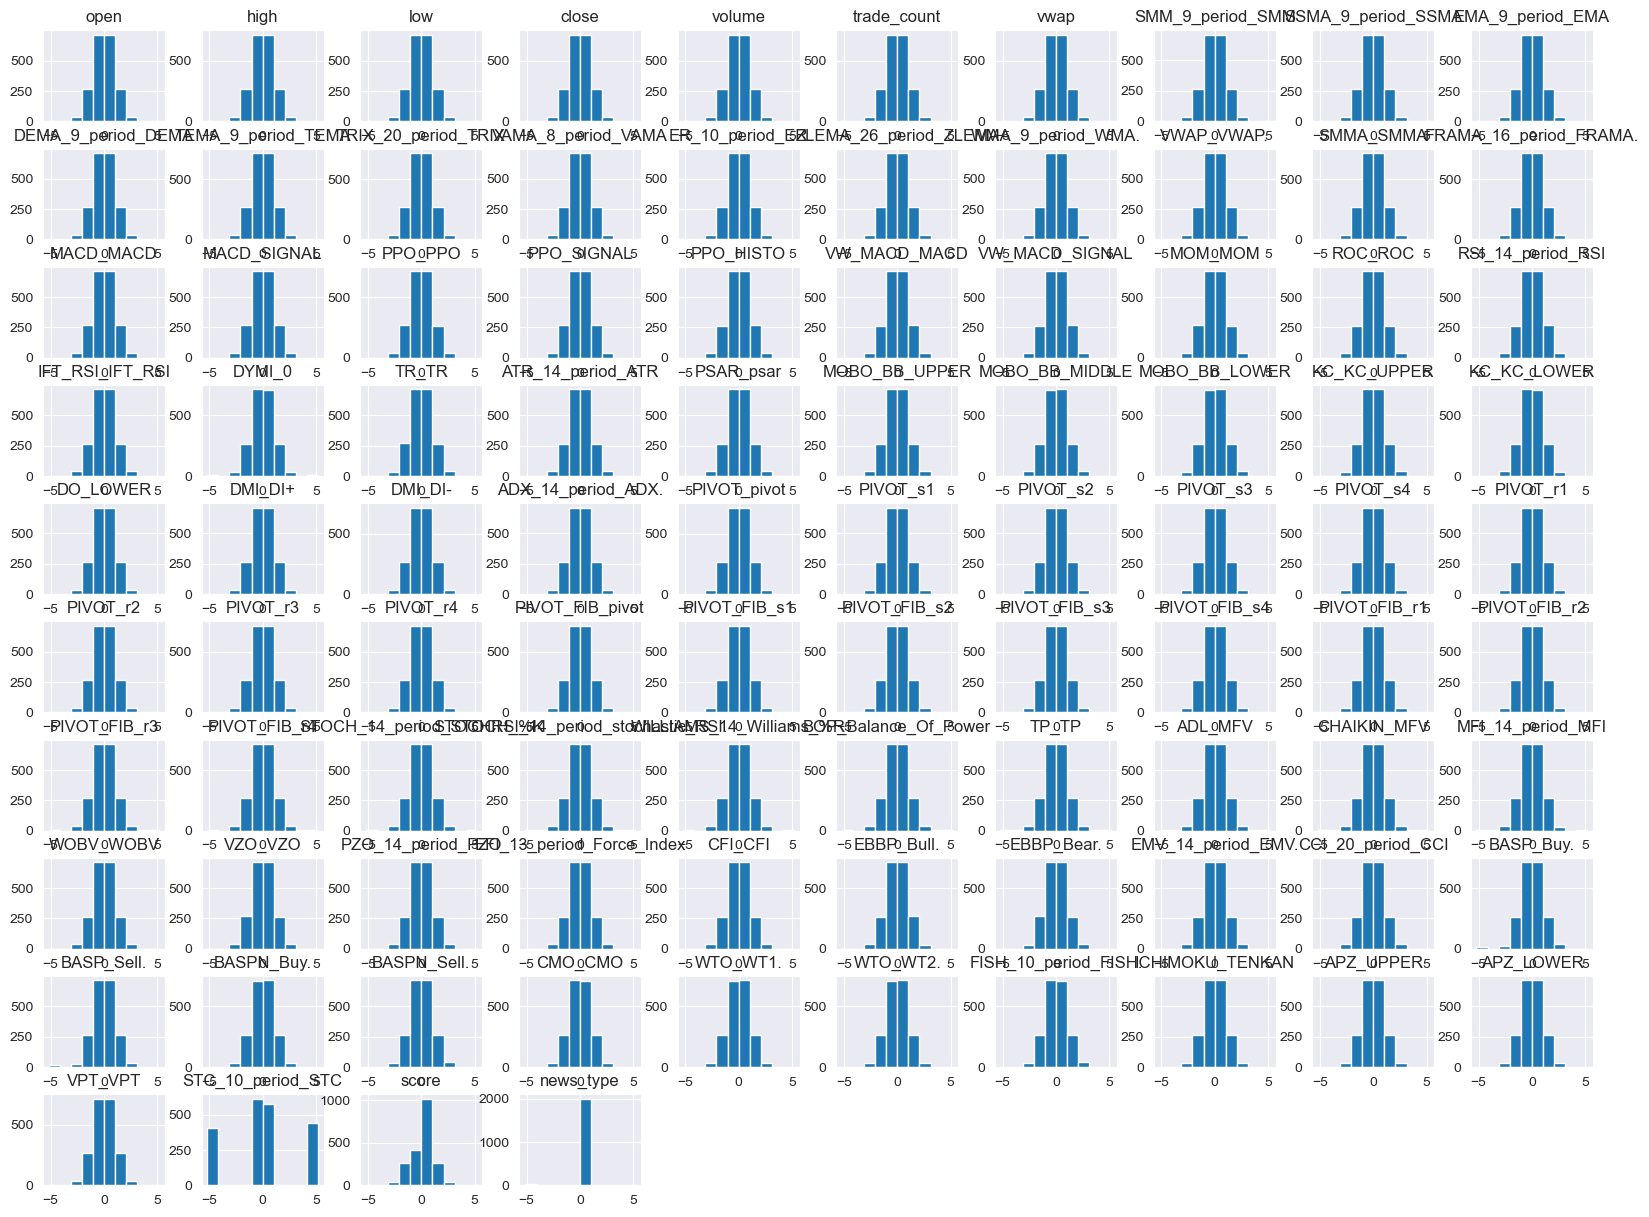

In [137]:
df_norm.hist(figsize=(20,15))

##### As we can see from the describe method of pandas DataFrame, the mean is 0 and std is 1 and from the above bell shape plots, now our dataset has a normal distribution

In [138]:
df_norm.tail()

open      high       low     close    volume  trade_count  \
date                                                                        
2024-02-20  2.860177  2.878859  2.878888  2.860301 -0.970801     0.036329   
2024-02-21  2.905906  2.909176  2.885562  2.934713 -1.911793    -0.118111   
2024-02-22  3.100082  3.104556  3.104866  3.114726 -1.093977     0.264997   
2024-02-23  5.199338  5.199338  5.199338  5.199338 -1.859363     0.160422   
2024-02-26  4.019460  3.355493  3.392284  3.224757 -1.836119    -0.081086   

                vwap  SMM_9_period_SMM  SSMA_9_period_SSMA  EMA_9_period_EMA  \
date                                                                           
2024-02-20  2.879553          2.879182            2.882316          2.882072   
2024-02-21  2.905213          2.891439            2.959469          2.956293   
2024-02-22  3.109422          3.126647            3.095853          3.096568   
2024-02-23  5.199338          3.619926            3.328835          3.356557   
2024-02-26  3.249336          5.199338            5.199338          5.199338   

            ...  WTO_WT1.  WTO_WT2.  FISH_10_period_FISH.  ICHIMOKU_TENKAN  \
date        ...                                                              
2024-02-20  ...  1.753525  1.467334              0.778281         2.878859   
2024-02-21  ...  1.893324  1.683836              1.039688         2.909176   
2024-02-22  ...  2.229945  1.873556              1.316941         3.104556   
2024-02-23  ...  2.411135  2.160838              1.571297         5.199338   
2024-02-26  ...  2.408946  2.302813              1.546755         5.199338   

            APZ_UPPER  APZ_LOWER   VPT_VPT  STC_10_period_STC     score  \
date                                                                      
2024-02-20   2.882094   2.882052  0.039318          -0.168709 -1.519235   
2024-02-21   2.957147   2.956510  0.049359          -0.029486  1.060099   
2024-02-22   3.096183   3.096038  0.065449           0.108820  1.016853   
2024-02-23   3.342952   3.339162  0.067272           0.286184  0.600224   
2024-02-26   5.199338   5.199338  0.063362           0.472237 -0.877331   

            news_type  
date                   
2024-02-20   0.007527  
2024-02-21   0.007527  
2024-02-22   0.007527  
2024-02-23   0.007527  
2024-02-26   0.007527  

[5 rows x 94 columns]

### Modeling

In [139]:
X = df.drop(columns=['close'], axis=1)
y = df['close']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

X_corr = df_corr.drop(columns=['close'], axis=1)
y_corr = df_corr['close']
X_corr_train, X_corr_test, y_corr_train, y_corr_test = train_test_split(X_corr, y_corr, test_size=0.33, random_state=42)

X_norm = df_norm.drop(columns=['close'], axis=1)
y_norm = df_norm['close']
X_norm_train, X_norm_test, y_norm_train, y_norm_test = train_test_split(X_norm, y_norm, test_size=0.33, random_state=42)

In [140]:
X_test.sort_index(inplace=True)
X_train.sort_index(inplace=True)
X_corr_test.sort_index(inplace=True)
X_corr_train.sort_index(inplace=True)
X_norm_test.sort_index(inplace=True)
X_norm_train.sort_index(inplace=True)

In [141]:
y_test.sort_index(inplace=True)
y_train.sort_index(inplace=True)
y_corr_test.sort_index(inplace=True)
y_corr_train.sort_index(inplace=True)
y_norm_test.sort_index(inplace=True)
y_norm_train.sort_index(inplace=True)

In [142]:
X_corr.tail()

open    high      low     volume  trade_count        vwap  \
date                                                                      
2024-02-20  179.19  180.46  178.405  9667959.0     103049.0  179.737550   
2024-02-21  179.95  180.99  178.520  7027857.0      96763.0  180.203631   
2024-02-22  181.82  183.42  181.240  9296459.0     111935.0  182.788280   
2024-02-23  183.81  185.20  183.190  7104018.0     108247.0  184.196089   
2024-02-26  183.75  184.46  182.480  7145393.0      98133.0  183.327353   

            SMM_9_period_SMM  SSMA_9_period_SSMA  EMA_9_period_EMA  \
date                                                                 
2024-02-20            175.79          175.553999        177.152321   
2024-02-21            176.03          176.147999        177.901857   
2024-02-22            179.03          176.917110        178.935486   
2024-02-23            179.73          177.702987        179.946388   
2024-02-26            179.87          178.331544        180.629111   

            DEMA_9_period_DEMA  ...   WTO_WT1.   WTO_WT2.  \
date                            ...                         
2024-02-20          179.037340  ...  64.227919  56.488435   
2024-02-21          180.009501  ...  66.508989  61.751517   
2024-02-22          181.448504  ...  70.805888  65.603433   
2024-02-23          182.765525  ...  74.240796  68.945898   
2024-02-26          183.430598  ...  74.235829  71.447876   

            FISH_10_period_FISH.  ICHIMOKU_TENKAN   APZ_UPPER   APZ_LOWER  \
date                                                                        
2024-02-20              1.916395         176.5375  183.303919  173.486390   
2024-02-21              2.355495         176.8025  184.035787  174.211576   
2024-02-22              2.787865         178.0175  185.027366  175.206759   
2024-02-23              3.213397         178.9075  186.023569  176.220655   
2024-02-26              3.172768         178.9075  186.753459  176.980729   

                 VPT_VPT  STC_10_period_STC     score  news_type  
date                                                              
2024-02-20  1.960313e+08          30.686989  0.979125        1.0  
2024-02-21  2.014374e+08          52.216634  0.998664        1.0  
2024-02-22  2.120985e+08          73.334500  0.998633        1.0  
2024-02-23  2.133708e+08          88.995794  0.998382        1.0  
2024-02-26  2.105560e+08          97.172730  0.997006        1.0  

[5 rows x 93 columns]

### Regression  Baseline Model using normalized data

In [ ]:
complexity = 5
complex_index_norm = get_complexity(X_norm_train, X_norm_test, y_norm_train, y_norm_test, complexity)
poly_ordinal_norm = make_column_transformer((PolynomialFeatures(include_bias=False, degree=complex_index_norm), make_column_selector(dtype_include=np.number)))

In [ ]:
alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge = Pipeline([('transformer', poly_ordinal_norm), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge.fit(X_norm_train, y_norm_train)

In [ ]:
regression_model = {'Ridge Regression Normalized': ridge }
reg_model_metrics(regression_model, X_norm_train, X_norm_test, y_norm_train, y_norm_test)
print_permutation_importance(ridge, df_norm, X_norm, X_norm_test, y_norm_test)

### Regression Models

In [ ]:
poly_degree = get_complexity(X_corr_train, X_corr_test, y_corr_train, y_corr_test, complexity)






poly_ordinal = make_column_transformer((PolynomialFeatures(include_bias=False, degree=poly_degree), make_column_selector(dtype_include=np.number)))

In [ ]:
linreg = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('linreg', LinearRegression())])
linreg.fit(X_corr_train, y_corr_train)

alphas = [0.001, 0.1, 1.0, 10.0, 100.0]
ridge1 = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('ridgereg', RidgeCV(alphas=alphas))])
ridge1.fit(X_corr_train, y_corr_train)

lasso = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('lasso_reg', Lasso(alpha=0.01, random_state=42))])
lasso.fit(X_corr_train, y_corr_train)

param_grid = {
    'clf__alpha': [0.1, 1, 10, 0.01],
    'clf__tol': [0.0001, 0.001]
}
pipeline_grid = Pipeline([('transformer', poly_ordinal), ('scaler', MinMaxScaler()), ('clf', HuberRegressor(max_iter=1000))])
grid_search = GridSearchCV(pipeline_grid, param_grid, scoring='r2', cv=10, return_train_score=True, n_jobs=-1)
# Fit the GridSearchCV object to the data
grid_search.fit(X_corr_train, y_corr_train)

rfr = Pipeline([('transformer', poly_ordinal), ('scaler', StandardScaler()), ('rfr', RandomForestRegressor(random_state=0))])
rfr.fit(X_corr_train, y_corr_train)

In [ ]:
regression_models = {'Linear Regression': linreg,
                     'Ridge Regression': ridge1,
                     'Lasso Regression': lasso,
                     'GridSearchCV': grid_search,
                     'RandomForestRegressor': rfr
                     }
reg_model_metrics(regression_models, X_corr_train, X_corr_test, y_corr_train, y_corr_test)